References
https://www.pyimagesearch.com/2017/02/20/text-skew-correction-opencv-python/


In this project, we are going to develop a very simple OCR for Devanagari Characters. We have previously developed a [CNN based Neural Network model](github.com/theonlyNischal/Devanagari-Handwritten-Character-Classificantion) to classify Devanagari characters. We will use that model to predict character from words/sentences/paragraph.

Our model has done perfect job of classifying Devanagari characters but the problem with such model is it expect a single image with a single character and they could give wrong output if image is not noise free. So a very versatile OCR should also focus intensively on character segmentation, noise removal and other image preprocessing technique.

The OCR pipeline we are going to follow is:
1. Image Acquisition
2. Image Preprocessing
3. CNN based Recognition of Devanagari Character



1. **Image Acquisition**

We can acquire images to be read via a simple digital camera or a scanner. After capturing the images via a camera we will store them in the project directory. Our CNN based model is limited to classify character without modifiers such as 

![Devanagari Modifiers](assets/devanagari_modifier.png)

In the next step of this OCR Project, we really want to work on Devanagari Character with modifiers.

2. **Image Preprocessing**

Image we captured via digital camera are prone to noises. Further we are limiting ourselves to images of words. So a very good character segmentation algorithm is also needed. Some image preprocessing task we are going to use are **binarization**, **noise removal**, **skew detection**, **character segmentation**, **thinning or skeletonization**.

The main objective of pre-processing is to organize  information so that the subsequent character recognition task becomes simpler.

**Binarization**
Here we will compare each pixel along HxW against a threshold. If the pixel is greater than threshold its value is set to maximum value else its value is set to 0.

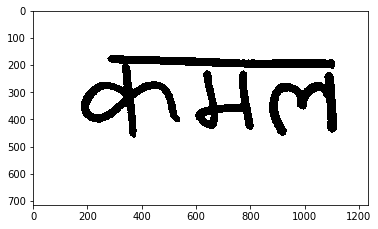

In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

kamal = cv.imread("Devanagari_Images/kamal.jpg")
kamal_gray = cv.cvtColor(kamal, cv.COLOR_BGR2GRAY)

retval, thresholded_kamal = cv.threshold(kamal_gray, 85, 255, cv.THRESH_BINARY)
plt.imshow(thresholded_kamal, cmap="gray")

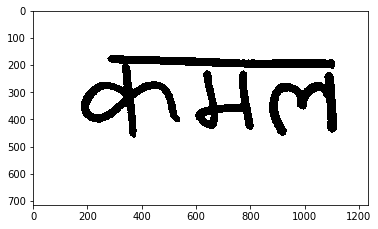

In [2]:
def binarization(img_path, threshold_value, maximum_value):
    image = cv.imread(img_path)
    image_gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    retval, thresholded_image = cv.threshold(image_gray, 
                        threshold_value, maximum_value, cv.THRESH_BINARY)
    
    return thresholded_image

img = "Devanagari_Images/kamal.jpg"
thresholded_image = binarization(img, 85, 255)
plt.imshow(thresholded_image, cmap="gray")

**Noise Removal**
When we acquire image from real world there is a very high chance that there will be noises in the image. Various noise removal filter can be applied to remove noises. Gaussian Blurring, Median Blurring are very common smoothing techniques. 

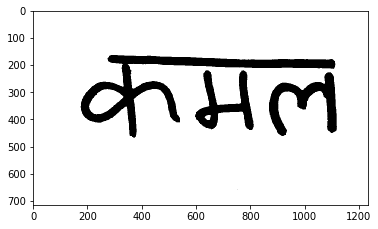

In [3]:
# 3x3 average filter
mask = np.ones((3,3))/9

filtered_image = cv.filter2D(thresholded_image, -1, mask)
# -1 means output will have same type as input image
plt.imshow(filtered_image, cmap="gray")

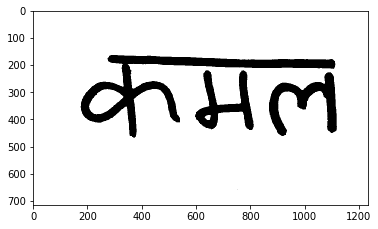

In [4]:
def noise_removal(thresholded_image):
    mask = np.ones((3,3))/9
    filtered_image = cv.filter2D(thresholded_image, -1, mask)
    # -1 means output will have same type as input image
    
    return filtered_image

filtered_image = noise_removal(thresholded_image)
plt.imshow(filtered_image, cmap="gray")

**Skew Correction**

Skew Correction process is very simple. First we need to have a binarized image with white text in a black bacground. Then we need to find (x, y) coordinates of all pixel values that are greater than 0, then use these coordinates to compute a rotated bounding box that contains all coordinates.

The minAreaRect function returns values in the range[-90, 0) as the rectangle rotates clockwise the angle value increases towards zero. When zero is reached, the angle is set back to -90 degrees again and the process continues.

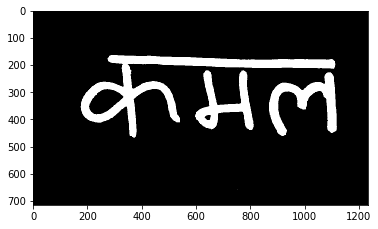

In [5]:
inverse_image = cv.bitwise_not(filtered_image)
plt.imshow(inverse_image, cmap="gray")

In [6]:
## finding angle of rotating bounding box

coords = np.column_stack(np.where(inverse_image > 0))
print(coords)

angle = cv.minAreaRect(coords)[-1]
print(angle)

if angle < -45:
    angle = -(90 + angle)
else:
    angle = -angle
    
print(angle)

[[161 290]
 [161 291]
 [161 292]
 ...
 [657 752]
 [657 753]
 [657 754]]
-1.0741699934005737
1.0741699934005737


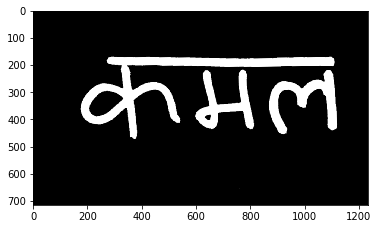

In [7]:
(h, w) = inverse_image.shape[:2]
center = (w//2, h//2)
M = cv.getRotationMatrix2D(center, angle, 1.0)
rotated = cv.warpAffine(inverse_image, M, (w, h), flags=cv.INTER_CUBIC,
                       borderMode = cv.BORDER_REPLICATE)

plt.imshow(rotated, cmap="gray")

In [8]:
def skew_correctness(filtered_image):
    inverse_image = cv.bitwise_not(filtered_image)
    coords = np.column_stack(np.where(inverse_image > 0))
    angle = cv.minAreaRect(coords)[-1]
    
    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = -angle
        
    (h, w) = inverse_image.shape[:2]
    center = (w//2, h//2)
    M = cv.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv.warpAffine(inverse_image, M, (w, h), flags=cv.INTER_CUBIC,
                       borderMode = cv.BORDER_REPLICATE)
    
    return rotated
    

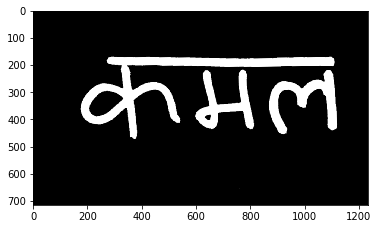

In [9]:
rotated_image = skew_correctness(filtered_image)
plt.imshow(rotated_image, cmap="gray")

**Character Segmentation**
Next we want to segment the given word into characters. This simple project expects input image to consist of words without modifiers like "kamala", we need to segment the word in "ka", "ma", "la".



